In [2]:
import matplotlib.pyplot as plt 
%matplotlib inline
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

Unlike bagging algorithms, which only controls for high variance in a model, boosting controls both the aspects (bias and variance),<br>
and is considered to be more effective.

## Loading Data

In [3]:
#Loading the Dataframe
Dataset_std = pd.read_pickle("Data_te_std.pkl")
Dataset_norm = pd.read_pickle("Data_te_norm.pkl") 
Attack_label = pd.read_pickle("Attack_label.pkl")
Attack_type = pd.read_pickle("Attack_type.pkl")

# Working with smaller Dataset first
from sklearn.utils.random import sample_without_replacement
indices = sample_without_replacement(Dataset_std.shape[0],Dataset_std.shape[0]/8 , random_state=22)
Dataset_norm_short = pd.DataFrame(Dataset_norm.loc[indices.tolist()])
Dataset_std_short = pd.DataFrame(Dataset_std.loc[indices.tolist()])
Attack_label_short = pd.DataFrame(Attack_label.loc[indices.tolist()])

# mapping for 6 class and then sampling
mapping_dict = {'DDoS_UDP': 1, 'DDoS_ICMP': 1, 'DDoS_HTTP': 1, 'DDoS_TCP': 1,
                'Port_Scanning': 2, 'Fingerprinting': 2, 'Vulnerability_scanner': 2,
                'MITM' : 3, 'XSS' : 4, 'SQL_injection': 4, 'Uploading':4, 
                'Backdoor': 5, 'Password': 5, 'Ransomware':5, 'Normal':6}
temp = Attack_type.map(mapping_dict)
Attack_type_short = pd.DataFrame(temp.loc[indices.tolist()])

In [4]:
# Oversampling
from imblearn.combine import SMOTEENN
sm = SMOTEENN(random_state= 22)
Dataset_res, Target_res = sm.fit_resample(Dataset_std_short, Attack_type_short)
print(Attack_type_short.value_counts(normalize = True))
print(Target_res.value_counts(normalize = True))

Attack_type
1              0.315539
4              0.197769
5              0.194677
6              0.152091
2              0.132522
3              0.007402
Name: proportion, dtype: float64
Attack_type
2              0.215795
1              0.212508
5              0.190340
6              0.175108
3              0.112149
4              0.094100
Name: proportion, dtype: float64


In [5]:
# Train Test split
X = Dataset_res.to_numpy() 
Y = Target_res.to_numpy(dtype='int')
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.2, random_state=22) 
print("Train set: ", X_train.shape) 
print("Test set: ", X_test.shape) 

Train set:  (3834, 36)
Test set:  (15337, 36)


## Adaboost with RF

In [6]:
import pickle as pkl
Features = pkl.load(open("Features_RFFS.pkl", "rb"))
X = Dataset_res[Features].to_numpy()
Y = Target_res.to_numpy(dtype='int')
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.2, random_state=22) 
print("Train set: ", X_train.shape) 
print("Test set: ", X_test.shape) 

Train set:  (3834, 11)
Test set:  (15337, 11)


In [27]:
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier

adc = AdaBoostClassifier(RandomForestClassifier(),
                         n_estimators=30, random_state=22)
adc.fit(X_train, Y_train)
Y_pred = adc.predict(X_test)
print("Training Score: ", adc.score(X_train, Y_train))
print("Test Score: ", adc.score(X_test, Y_test))

Training Score:  0.9882629107981221
Test Score:  0.9688987416052683


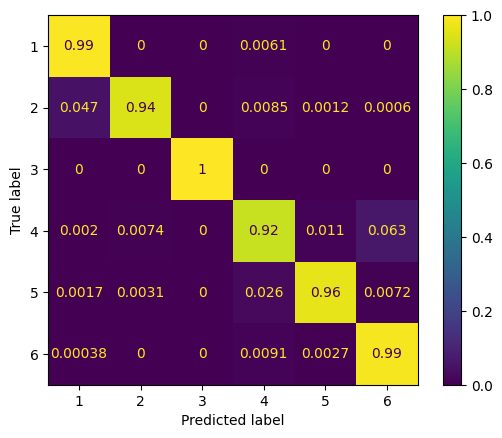

Average Accuracy: 0.9688987416052683
   Precision    Recall  F1-Score
1   0.951740  0.993891  0.972359
2   0.993631  0.942598  0.967442
3   1.000000  1.000000  1.000000
4   0.901857  0.916442  0.909091
5   0.990172  0.962142  0.975956
6   0.957259  0.987833  0.972305


In [28]:
from sklearn import metrics

cm = metrics.confusion_matrix(Y_test, Y_pred, labels=adc.classes_, normalize= 'true')
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=adc.classes_)
disp.plot()
plt.show()

print("Average Accuracy:",metrics.accuracy_score(Y_test, Y_pred)) # Model Accuracy
df_metric = pd.DataFrame({'Precision':metrics.precision_score(Y_test, Y_pred, average=None),
                        'Recall': metrics.recall_score(Y_test, Y_pred, average=None),
                        'F1-Score': metrics.f1_score(Y_test, Y_pred, average=None)}, index= adc.classes_)
print(df_metric)

## Voting Ensemble 5 Class

In [24]:
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier

linsvc = LinearSVC (C=1)
svc = SVC(kernel='rbf', C= 1e4, decision_function_shape='ovo', probability= True)
knn = KNeighborsClassifier(n_neighbors= 6, weights= 'distance', algorithm= 'auto', leaf_size= 20, p= 1)
rfc = RandomForestClassifier(n_estimators=80, max_samples= 0.8, max_depth=11,
                             max_features= 0.9, criterion= 'gini', random_state=22, oob_score= True)

vc = VotingClassifier(estimators=[('knn', knn), ('rfc', rfc), ('svc', svc)], voting='soft')  #  , ('linsvc', linsvc)
vc.fit(X_train, Y_train)
Y_pred = vc.predict(X_test)


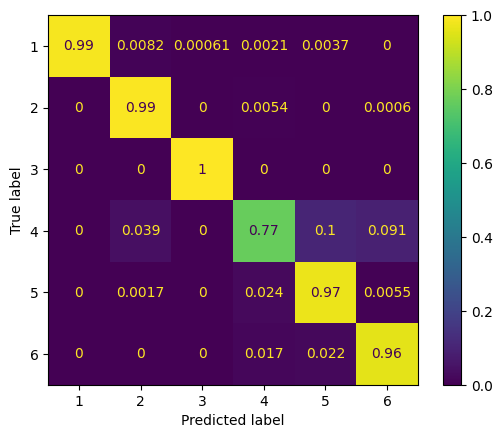

Average Accuracy: 0.9602921040620721
   Precision    Recall  F1-Score
1   1.000000  0.985339  0.992615
2   0.973373  0.993958  0.983558
3   0.998830  1.000000  0.999415
4   0.890368  0.766173  0.823615
5   0.926941  0.969304  0.947649
6   0.942889  0.960456  0.951592


In [30]:
from sklearn import metrics

cm = metrics.confusion_matrix(Y_test, Y_pred, labels=vc.classes_, normalize= 'true')
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=vc.classes_)
disp.plot()
plt.show()

print("Average Accuracy:",metrics.accuracy_score(Y_test, Y_pred)) # Model Accuracy
df_metric = pd.DataFrame({'Precision':metrics.precision_score(Y_test, Y_pred, average=None),
                        'Recall': metrics.recall_score(Y_test, Y_pred, average=None),
                        'F1-Score': metrics.f1_score(Y_test, Y_pred, average=None)}, index= vc.classes_)
print(df_metric)

## Voting Ensemble Outlier

In [54]:
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.combine import SMOTEENN
import numpy as np

class SampleReducer(BaseEstimator, TransformerMixin):
    def __init__(self, factor=8):
        self.factor = factor
        
    def fit(self, X, y=None):
        return self        
    
    def transform(self, X, y=None):
        n_samples = len(X)
        reduced_n_samples = n_samples // self.factor
        indices = np.random.choice(n_samples, reduced_n_samples, replace=False)
        return X[indices]
        


class SMOTEENNTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, random_state=None):
        self.random_state = random_state
        self.smoteenn = SMOTEENN(random_state=self.random_state)
        
    def fit(self, X, y):
        obj = self.smoteenn.fit(X, y)
        return obj
        
    def transform(self, X):
        X_trans, Y_trans = self.smoteenn.fit_resample(X, y)
        return X_trans, Y_trans
        
    

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import pandas as pd

pipe_svc = make_pipeline(StandardScaler(), SampleReducer(factor=30))
X =  pd.read_pickle("Data_tar_enc.pkl")
Y = pd.read_pickle("Attack_label.pkl")
X_transformed = pipe_svc.fit_transform(X)

print(f'Original shape: {X.shape}')
print(f'Transformed shape: {X_transformed.shape}')

Original shape: (157800, 36)
Transformed shape: (5260, 36)


In [55]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, Normalizer

from sklearn.svm import SVC
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest


sm = SMOTEENNTransformer(random_state=22)

svc = SVC(kernel='rbf', C= 500)
lof = LocalOutlierFactor(n_neighbors=6, novelty=True, metric= 'euclidean', leaf_size=20)
If = IsolationForest(random_state=22, max_samples=0.5,  max_features= 0.5, n_estimators=25, bootstrap=False) #, contamination ?

pipe_svc = make_pipeline(StandardScaler(), SampleReducer(factor=30), sm)
pipe_svc

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('samplereducer', SampleReducer(factor=30)),
                ('smoteenntransformer', SMOTEENNTransformer(random_state=22))])

In [56]:
X = pd.read_pickle("Data_tar_enc.pkl")
Y = pd.read_pickle("Attack_label.pkl")

pipe_svc.fit_transform(X, Y)

ValueError: Found input variables with inconsistent numbers of samples: [5260, 157800]